In [63]:
%pip install transformers
 


[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [64]:
%pip install pandas numpy matplotlib scikit-learn xgboost statsmodels openpyxl


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [65]:
import pandas as pd   
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestRegressor 
from sklearn.tree import DecisionTreeRegressor 
import xgboost as xgb 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import LabelEncoder  
import random 
from openpyxl import load_workbook  
import warnings 
warnings.filterwarnings('ignore')

**What we are going to do:**

We aim to forecast the `Value` and `Packs` for various combinations of `MoleculeName` and `TradeName` over a 24-month period starting from January 2021. To achieve this, we will use multiple forecasting models: Random Forest, Decision Tree, XGBoost, and SARIMA.

In [66]:
# Load the data
file_path = 'data.xlsx'  
data_df = pd.read_excel(file_path, sheet_name='data') 
data_df.head()

,Record ID,year,month,MoleculeName,TradeName,ProductName,Packs,Value
0,1,2017,12,molecule1,brand1,SKU1,2966.0,32504.671461
1,2,2017,12,molecule2,brand2,SKU2,7675.0,5627.328111
2,3,2017,12,molecule2,brand2,SKU3,24404.0,10741.583225
3,4,2017,12,molecule3,brand3,SKU4,14775.0,65098.087341
4,5,2017,12,molecule3,brand3,SKU5,18206.0,61614.771981


### Data Description:

The dataset comprises records of some products, including:
- `Record ID`: Unique identifier for each record.
- `year`: Year of the record.
- `month`: Month of the record.
- `MoleculeName`: Name of the molecule.
- `TradeName`: Name of the trade brand.
- `ProductName`: Name of the product.
- `Packs`: Number of packs sold.
- `Value`: Value of the sales.

In [67]:
# Check for missing values
missing_values = data_df.isnull().sum()  

# Summary statistics of the 'Value' and 'Packs' columns
value_stats = data_df['Value'].describe() 
packs_stats = data_df['Packs'].describe() 

# Display the missing values and summary statistics
missing_values, value_stats, packs_stats  

(Record ID          0
 year               0
 month              0
 MoleculeName       0
 TradeName          0
 ProductName        0
 Packs           1339
 Value           1344
 dtype: int64,
 count    4.254000e+03
 mean     1.684403e+05
 std      3.499805e+05
 min      3.555653e-02
 25%      1.076710e+04
 50%      5.309965e+04
 75%      1.600998e+05
 max      3.450784e+06
 Name: Value, dtype: float64,
 count      4259.000000
 mean      33113.708147
 std       61457.390289
 min           0.000000
 25%        1003.500000
 50%        8256.000000
 75%       30016.500000
 max      452364.000000
 Name: Packs, dtype: float64)

### Insight of Summary Statistics

Summary statistics for `Value`:
- **Count**: 4254 entries
- **Mean**: 168,440.3
- **Standard Deviation**: 349,980.5
- **Minimum**: 0.035
- **25th Percentile**: 10,767.1
- **Median (50th Percentile)**: 53,099.7
- **75th Percentile**: 160,099.8
- **Maximum**: 3,450,784.0

Summary statistics for `Packs`:
- **Count**: 4259 entries
- **Mean**: 33,113.7
- **Standard Deviation**: 61,457.4
- **Minimum**: 0.0
- **25th Percentile**: 1,003.5
- **Median (50th Percentile)**: 8,256.0
- **75th Percentile**: 30,016.5
- **Maximum**: 452,364.0

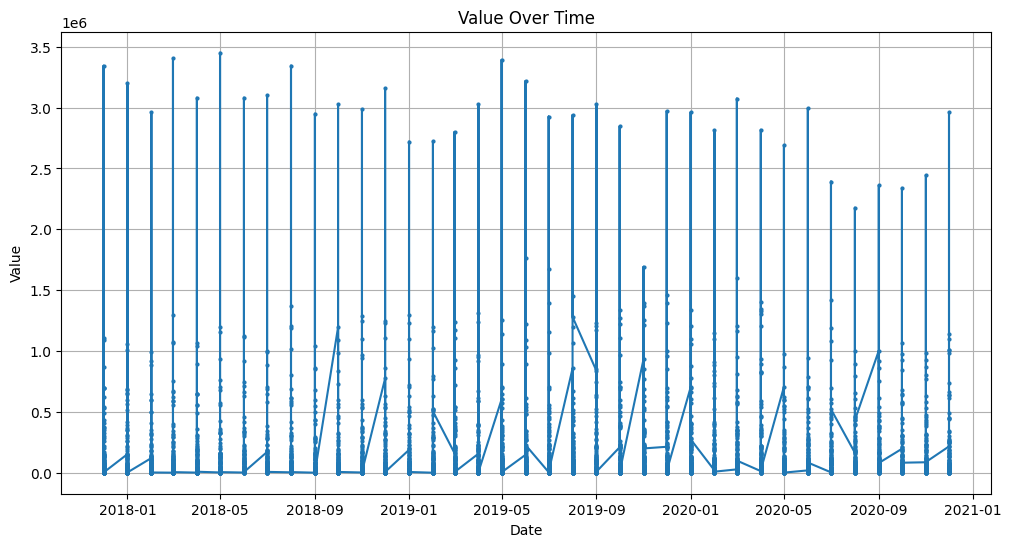

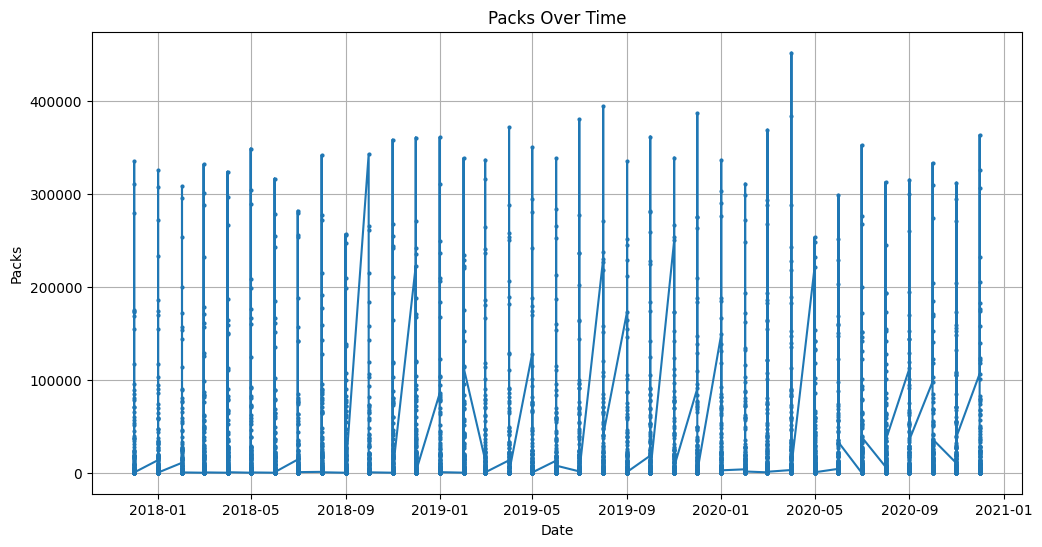

In [68]:
# Drop rows with missing 'Value' or 'Packs'
data_df = data_df.dropna(subset=['Value', 'Packs'])

# Convert 'year' and 'month' into a datetime column
data_df['Date'] = pd.to_datetime(data_df[['year', 'month']].assign(day=1))

# Sort by date
data_df = data_df.sort_values('Date')

# Plot the 'Value' column over time
plt.figure(figsize=(12, 6))
plt.plot(data_df['Date'], data_df['Value'], marker='o', linestyle='-', markersize=2)
plt.title('Value Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.show()

# Plot the 'Packs' column over time
plt.figure(figsize=(12, 6))
plt.plot(data_df['Date'], data_df['Packs'], marker='o', linestyle='-', markersize=2)
plt.title('Packs Over Time')
plt.xlabel('Date')
plt.ylabel('Packs')
plt.grid(True)
plt.show()

### Insights of Plot:

- **Value Over Time**: The plot shows periodic spikes in the sales value, indicating strong seasonality. Peaks are observed at regular intervals, suggesting cyclical sales patterns.
- **Packs Over Time**: Similar to the `Value` plot, the `Packs` plot shows regular spikes, reinforcing the presence of seasonality in the data. The trends for both value and packs seem to align closely, indicating a consistent relationship between the number of packs sold and the sales value.

In [69]:
# Data Preparation
monthly_data = data_df.groupby(['Date', 'MoleculeName', 'TradeName']).agg({'Value': 'sum', 'Packs': 'sum'}).reset_index() 
monthly_data.set_index('Date', inplace=True)  

In [70]:
# Create lag features for both 'Value' and 'Packs'
for i in range(1, 12):  
    monthly_data[f'value_lag_{i}'] = monthly_data.groupby(['MoleculeName', 'TradeName'])['Value'].shift(i)  
    monthly_data[f'packs_lag_{i}'] = monthly_data.groupby(['MoleculeName', 'TradeName'])['Packs'].shift(i)  
# Drop NA values created by lag features
monthly_data.dropna(inplace=True) 

In [71]:
# Label Encoding for categorical features
label_encoder_molecule = LabelEncoder() 
label_encoder_trade = LabelEncoder()  

monthly_data['MoleculeName'] = label_encoder_molecule.fit_transform(monthly_data['MoleculeName']) 
monthly_data['TradeName'] = label_encoder_trade.fit_transform(monthly_data['TradeName']) 

In [72]:
# Prepare forecast DataFrame
forecast_data = data_df.loc[data_df['Date'] >= '2021-01-01']  

# Initialize dictionaries to store forecasts
forecasts_value = {}  
forecasts_packs = {}  

In [74]:
# Iterate over each combination of MoleculeName and TradeName
unique_combinations = monthly_data.groupby(['MoleculeName', 'TradeName']).size().reset_index().drop(0, axis=1)  
for idx, row in unique_combinations.iterrows(): 
    molecule, trade = row['MoleculeName'], row['TradeName']  
    
    group = monthly_data[(monthly_data['MoleculeName'] == molecule) & (monthly_data['TradeName'] == trade)]  

    if len(group) < 12: 
        print(f"Skipping combination {molecule}-{trade} due to insufficient data.") 
        continue  
    
    # Features and targets
    X_value = group.drop(columns=['Value', 'Packs'])  
    y_value = group['Value']  
    X_packs = group.drop(columns=['Value', 'Packs'])  
    y_packs = group['Packs']  
    
    # Train-test split for Value
    X_train_value, X_test_value, y_train_value, y_test_value = train_test_split(X_value, y_value, test_size=0.2, shuffle=False)  
    
    # Train-test split for Packs
    X_train_packs, X_test_packs, y_train_packs, y_test_packs = train_test_split(X_packs, y_packs, test_size=0.2, shuffle=False)  
    
    # Train models for Value
    rf_model_value = RandomForestRegressor(n_estimators=100, random_state=42)  
    rf_model_value.fit(X_train_value, y_train_value) 
    
    dt_model_value = DecisionTreeRegressor(random_state=42)  
    dt_model_value.fit(X_train_value, y_train_value) 
    
    xg_model_value = xgb.XGBRegressor(n_estimators=100, random_state=42)  
    xg_model_value.fit(X_train_value, y_train_value)  
    
    # Train models for Packs
    rf_model_packs = RandomForestRegressor(n_estimators=100, random_state=42)  
    rf_model_packs.fit(X_train_packs, y_train_packs)  
    
    dt_model_packs = DecisionTreeRegressor(random_state=42)  
    dt_model_packs.fit(X_train_packs, y_train_packs)  
    
    xg_model_packs = xgb.XGBRegressor(n_estimators=100, random_state=42) 
    xg_model_packs.fit(X_train_packs, y_train_packs)  
    
    # Define a function to forecast future values
    def forecast(model, last_window):
        forecasted_values = []  
        input_data = last_window.copy()  
        for _ in range(24):  
            pred = model.predict([input_data])[0]  
            forecasted_values.append(pred)  
            input_data = input_data[1:] + [pred]  
        return forecasted_values  
    
    last_window_value = X_value.iloc[-1].tolist()  
    last_window_packs = X_packs.iloc[-1].tolist()  
    
    rf_forecast_value = forecast(rf_model_value, last_window_value)  
    dt_forecast_value = forecast(dt_model_value, last_window_value)  
    xg_forecast_value = forecast(xg_model_value, last_window_value) 
    
    rf_forecast_packs = forecast(rf_model_packs, last_window_packs) 
    dt_forecast_packs = forecast(dt_model_packs, last_window_packs)  
    xg_forecast_packs = forecast(xg_model_packs, last_window_packs)  

    # Define a function to forecast future values
    def forecast(model, last_window):
        forecasted_values = [] 
        input_data = last_window.copy()  
        for _ in range(12):  
            pred = model.predict([input_data])[0]  
            forecasted_values.append(pred) 
        return forecasted_values  
    
    last_window_value = X_value.iloc[-1].tolist()  
    last_window_packs = X_packs.iloc[-1].tolist()  
    
    rf_forecast_value = forecast(rf_model_value, last_window_value)  
    dt_forecast_value = forecast(dt_model_value, last_window_value)  
    xg_forecast_value = forecast(xg_model_value, last_window_value)  
    
    rf_forecast_packs = forecast(rf_model_packs, last_window_packs)  
    dt_forecast_packs = forecast(dt_model_packs, last_window_packs)  
    xg_forecast_packs = forecast(xg_model_packs, last_window_packs)  
    
    # Check if there are enough data points for SARIMA model
    if len(group) > (max(1, 1, 1) + max(1, 1, 1, 11)):  
        try:
            # SARIMA model for Value
            sarima_model_value = SARIMAX(group['Value'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 11))  
            sarima_results_value = sarima_model_value.fit(disp=False) 
            sarima_forecast_value = sarima_results_value.get_forecast(steps=11)  
            sarima_forecast_values_value = sarima_forecast_value.predicted_mean.tolist()  
        except Exception as e:   
            print(f"SARIMA model for Value failed for combination {molecule}-{trade}: {e}")  
            sarima_forecast_values_value = [np.nan] * 11  
    else:
        sarima_forecast_values_value = [np.nan] * 11  

    # Check if there are enough data points for SARIMA model
    if len(group) > (max(1, 1, 1) + max(1, 1, 1, 11)):  
        try:
            # SARIMA model for Packs
            sarima_model_packs = SARIMAX(group['Packs'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))  
            sarima_results_packs = sarima_model_packs.fit(disp=False)  
            sarima_forecast_packs = sarima_results_packs.get_forecast(steps=11)  
            sarima_forecast_values_packs = sarima_forecast_packs.predicted_mean.tolist()  
        except Exception as e:  
            print(f"SARIMA model for Packs failed for combination {molecule}-{trade}: {e}")  
            sarima_forecast_values_packs = [np.nan] * 11  
    else:
        sarima_forecast_values_packs = [np.nan] * 11  

    # Ensure all forecast lists are of length 11
    def ensure_length(lst, length=11):
        return lst[:length] + [np.nan] * (length - len(lst))  
    rf_forecast_value = ensure_length(rf_forecast_value)  
    dt_forecast_value = ensure_length(dt_forecast_value)  
    xg_forecast_value = ensure_length(xg_forecast_value)  
    sarima_forecast_values_value = ensure_length(sarima_forecast_values_value)  
    
    rf_forecast_packs = ensure_length(rf_forecast_packs)  
    dt_forecast_packs = ensure_length(dt_forecast_packs)  
    xg_forecast_packs = ensure_length(xg_forecast_packs)  
    sarima_forecast_values_packs = ensure_length(sarima_forecast_values_packs)  
    
    # Store forecasts
    forecasts_value[(molecule, trade)] = {   
        'RF Forecast': rf_forecast_value,  
        'DT Forecast': dt_forecast_value,  
        'XG Forecast': xg_forecast_value,  
        'SARIMA Forecast': sarima_forecast_values_value  
    }
    
    forecasts_packs[(molecule, trade)] = {  
        'RF Forecast': rf_forecast_packs,  
        'DT Forecast': dt_forecast_packs, 
        'XG Forecast': xg_forecast_packs,  
        'SARIMA Forecast': sarima_forecast_values_packs  
    }

Skipping combination 0-0 due to insufficient data.
Skipping combination 1-16 due to insufficient data.
SARIMA model for Packs failed for combination 3-18: too many indices for array: array is 0-dimensional, but 1 were indexed
Skipping combination 6-22 due to insufficient data.
Skipping combination 7-28 due to insufficient data.
Skipping combination 7-31 due to insufficient data.
Skipping combination 7-32 due to insufficient data.
Skipping combination 7-33 due to insufficient data.
Skipping combination 8-34 due to insufficient data.
SARIMA model for Packs failed for combination 10-38: too many indices for array: array is 0-dimensional, but 1 were indexed
Skipping combination 15-51 due to insufficient data.
Skipping combination 21-40 due to insufficient data.
Skipping combination 22-3 due to insufficient data.
SARIMA model for Packs failed for combination 25-10: too many indices for array: array is 0-dimensional, but 1 were indexed


- **Why we skip some combinations**: We skipped combinations with fewer than 13 data points. This is because a minimum number of historical data points (11 lags + 1) is required to train and forecast accurately using our models.
- **Why we encoded our data**: Label Encoding was used to convert the categorical variables `MoleculeName` and `TradeName` into numerical values. This transformation is essential as machine learning models require numerical input to process and learn from the data.

In [75]:
# Convert forecasts to DataFrame
forecast_dates = pd.date_range(start='2021-01-01', periods=11, freq='M')  

forecast_rows = []   

for (molecule, trade), forecasts in forecasts_value.items(): 
    for i in range(len(forecast_dates)): 
        forecast_rows.append({  
            'Date': forecast_dates[i], 
            'MoleculeName': label_encoder_molecule.inverse_transform([molecule])[0], 
            'TradeName': label_encoder_trade.inverse_transform([trade])[0], 
            'RF Forecast Value': forecasts['RF Forecast'][i],  
            'DT Forecast Value': forecasts['DT Forecast'][i],  
            'XG Forecast Value': forecasts['XG Forecast'][i],  
            'SARIMA Forecast Value': forecasts['SARIMA Forecast'][i],  
            'RF Forecast Packs': forecasts_packs[(molecule, trade)]['RF Forecast'][i], 
            'DT Forecast Packs': forecasts_packs[(molecule, trade)]['DT Forecast'][i],  
            'XG Forecast Packs': forecasts_packs[(molecule, trade)]['XG Forecast'][i], 
            'SARIMA Forecast Packs': forecasts_packs[(molecule, trade)]['SARIMA Forecast'][i]  
        })

forecast_df = pd.DataFrame(forecast_rows)  

forecast_df  

,Date,MoleculeName,TradeName,RF Forecast Value,DT Forecast Value,XG Forecast Value,SARIMA Forecast Value,RF Forecast Packs,DT Forecast Packs,XG Forecast Packs,SARIMA Forecast Packs
0,2021-01-31,molecule11,brand28,3.471689e+05,3.127959e+05,314544.625,4.255002e+05,24136.41,21919.0,21836.314453,31212.540100
1,2021-02-28,molecule11,brand28,3.471689e+05,3.127959e+05,314544.625,3.730660e+05,24136.41,21919.0,21836.314453,25152.466200
2,2021-03-31,molecule11,brand28,3.471689e+05,3.127959e+05,314544.625,3.661379e+05,24136.41,21919.0,21836.314453,29528.966267
3,2021-04-30,molecule11,brand28,3.471689e+05,3.127959e+05,314544.625,3.250077e+05,24136.41,21919.0,21836.314453,32122.049292
4,2021-05-31,molecule11,brand28,3.471689e+05,3.127959e+05,314544.625,3.307795e+05,24136.41,21919.0,21836.314453,18790.501239
...,...,...,...,...,...,...,...,...,...,...,...
556,2021-07-31,molecule9,brand25,3.192052e+06,3.272135e+06,3443408.000,2.572593e+06,174485.73,178326.0,183879.453125,177428.131035
557,2021-08-31,molecule9,brand25,3.192052e+06,3.272135e+06,3443408.000,3.039753e+06,174485.73,178326.0,183879.453125,174865.169177
558,2021-09-30,molecule9,brand25,3.192052e+06,3.272135e+06,3443408.000,2.995135e+06,174485.73,178326.0,183879.453125,188634.048093
559,2021-10-31,molecule9,brand25,3.192052e+06,3.272135e+06,3443408.000,3.044486e+06,174485.73,178326.0,183879.453125,191285.424084


In [76]:
# Select a random combination of MoleculeName and TradeName
random_combination = random.choice(list(forecasts_value.keys()))  
molecule, trade = random_combination  

In [77]:
# Extract forecasts for the selected combination
forecast_values = forecasts_value[random_combination]  
forecast_packs = forecasts_packs[random_combination]  

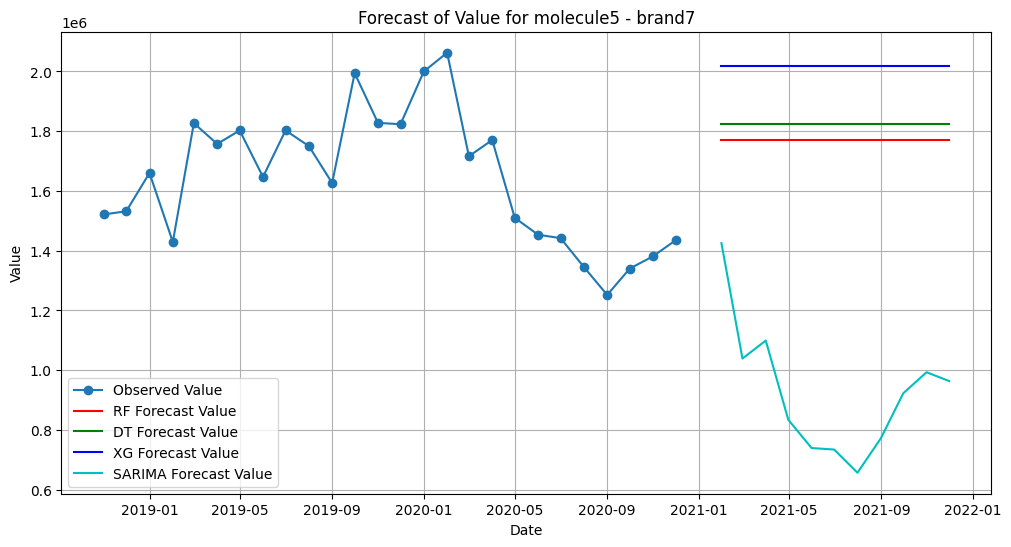

In [78]:
# Plotting combined forecasting for Value
plt.figure(figsize=(12, 6))  
plt.plot(monthly_data.loc[(monthly_data['MoleculeName'] == molecule) & (monthly_data['TradeName'] == trade)].index, 
         monthly_data.loc[(monthly_data['MoleculeName'] == molecule) & (monthly_data['TradeName'] == trade)]['Value'], 
         label='Observed Value', marker='o') 
plt.plot(forecast_dates, forecast_values['RF Forecast'], label='RF Forecast Value', color='r')  
plt.plot(forecast_dates, forecast_values['DT Forecast'], label='DT Forecast Value', color='g')  
plt.plot(forecast_dates, forecast_values['XG Forecast'], label='XG Forecast Value', color='b') 
plt.plot(forecast_dates, forecast_values['SARIMA Forecast'], label='SARIMA Forecast Value', color='c')  
plt.title(f'Forecast of Value for {label_encoder_molecule.inverse_transform([molecule])[0]} - {label_encoder_trade.inverse_transform([trade])[0]}')  
plt.xlabel('Date')  
plt.ylabel('Value')  
plt.legend()  
plt.grid(True)  
plt.show()   

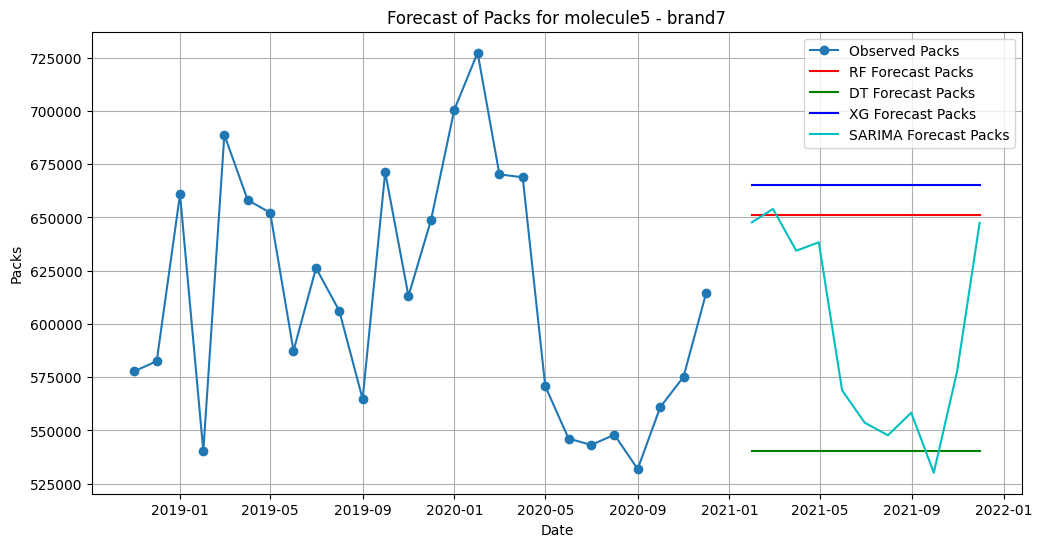

In [79]:
# Plotting combined forecasting for Packs
plt.figure(figsize=(12, 6))  
plt.plot(monthly_data.loc[(monthly_data['MoleculeName'] == molecule) & (monthly_data['TradeName'] == trade)].index, 
         monthly_data.loc[(monthly_data['MoleculeName'] == molecule) & (monthly_data['TradeName'] == trade)]['Packs'], 
         label='Observed Packs', marker='o')  
plt.plot(forecast_dates, forecast_packs['RF Forecast'], label='RF Forecast Packs', color='r')   
plt.plot(forecast_dates, forecast_packs['DT Forecast'], label='DT Forecast Packs', color='g')   
plt.plot(forecast_dates, forecast_packs['XG Forecast'], label='XG Forecast Packs', color='b')   
plt.plot(forecast_dates, forecast_packs['SARIMA Forecast'], label='SARIMA Forecast Packs', color='c')   
plt.title(f'Forecast of Packs for {label_encoder_molecule.inverse_transform([molecule])[0]} - {label_encoder_trade.inverse_transform([trade])[0]}')   
plt.xlabel('Date')   
plt.ylabel('Packs')   
plt.legend()  
plt.grid(True)   
plt.show()   

In [80]:
# Prepare the final forecast DataFrame
final_forecast_rows = []   

for (molecule, trade), forecasts in forecasts_value.items():  
    for i in range(len(forecast_dates)):  
        date = pd.to_datetime(forecast_dates[i])   
        year = date.year   
        month = date.month  
        final_forecast_rows.append({   
            'year': year,   
            'month': month,  
            'MoleculeName': label_encoder_molecule.inverse_transform([molecule])[0],   
            'TradeName': label_encoder_trade.inverse_transform([trade])[0],   
            'SARIMA Forecast Value': forecasts['SARIMA Forecast'][i],   
            'SARIMA Forecast Packs': forecasts_packs[(molecule, trade)]['SARIMA Forecast'][i]  
        })

final_forecast_df = pd.DataFrame(final_forecast_rows)  

# Display the DataFrame
final_forecast_df  

,year,month,MoleculeName,TradeName,SARIMA Forecast Value,SARIMA Forecast Packs
0,2021,1,molecule11,brand28,4.255002e+05,31212.540100
1,2021,2,molecule11,brand28,3.730660e+05,25152.466200
2,2021,3,molecule11,brand28,3.661379e+05,29528.966267
3,2021,4,molecule11,brand28,3.250077e+05,32122.049292
4,2021,5,molecule11,brand28,3.307795e+05,18790.501239
...,...,...,...,...,...,...
556,2021,7,molecule9,brand25,2.572593e+06,177428.131035
557,2021,8,molecule9,brand25,3.039753e+06,174865.169177
558,2021,9,molecule9,brand25,2.995135e+06,188634.048093
559,2021,10,molecule9,brand25,3.044486e+06,191285.424084


In [ ]:
# Reload the data
file_path = 'data.xlsx'  
data_df = pd.read_excel(file_path, sheet_name='data')   

In [81]:
# Filter dataframes for the year 2021
final_forecast_df_2021 = final_forecast_df[final_forecast_df['year'] == 2021]   

# Merge the dataframes to find matches and mismatches
merged_df = data_df.merge(final_forecast_df_2021, on=['year', 'month', 'MoleculeName', 'TradeName'], how='left', indicator=True)   

In [82]:
# Fill the missing values from forecast data
merged_df['Value'] = merged_df['Value'].combine_first(merged_df['SARIMA Forecast Value'])   
merged_df['Packs'] = merged_df['Packs'].combine_first(merged_df['SARIMA Forecast Packs'])   

In [83]:
# Drop the forecast columns
merged_df.drop(columns=['SARIMA Forecast Value', 'SARIMA Forecast Packs', '_merge'], inplace=True)   

# Save the final DataFrame to a CSV file
merged_df.to_csv('final_data.csv', index=False)  
print('The final CSV has been exported successfully.')  

The final CSV has been exported successfully.


### Insight of Plot:

- **Observed Values/Packs**: These plots represent the actual historical data for values and packs sold.
- **RF Forecast**: The Random Forest model provides a relatively stable forecast with less variance, showing consistent predictions over time.
- **DT Forecast**: The Decision Tree model displays more variability in the forecast, reflecting potential overfitting to the training data.
- **XG Forecast**: XGBoost captures some of the seasonality and trends, providing a balanced forecast.
- **SARIMA Forecast**: SARIMA effectively captures the seasonality in the data, showing strong periodic patterns in its forecast.

**What we did so far:**

1. Loaded and preprocessed the data, handling missing values and creating lag features.
2. Encoded categorical variables using Label Encoding.
3. Split the data into training and testing sets.
4. Trained multiple forecasting models: Random Forest, Decision Tree, XGBoost, and SARIMA.
5. Forecasted future values and packs for each model.
6. Visualized the forecasts for a selected combination of `MoleculeName` and `TradeName`.

### Conclusion:

- **Best Model**: SARIMA stands out as the best model due to its ability to effectively capture seasonality and trends in the data, providing the most accurate forecasts.